In [ ]:
import pandas as pd

# XLSX fájl beolvasása
df = pd.read_excel("adat.xlsx")

# CSV fájlba mentés
df.to_csv("adat.csv", index=False)

Az adatkészlet oszlopnevei:
Index(['DATE', 'PRICE-AVG', 'PRICE-MAX', 'PRICE-MIN', 'TEMP', 'PREC'], dtype='object')

Hiányzó értékek száma oszloponként:
DATE          0
PRICE-AVG    13
PRICE-MAX     8
PRICE-MIN     8
TEMP         16
PREC          9
dtype: int64

Hiányzó TEMP értékek imputálása után:
           DATE       TEMP
1536 2022-04-03  21.222222
1537 2022-04-04  20.984444
1538 2022-04-05  20.746667
1539 2022-04-06  20.508889
1540 2022-04-07  20.271111
1541 2022-04-08  20.033333
1542 2022-04-09  19.795556
1543 2022-04-10  19.557778

Negatív PREC értékek száma: 24
          DATE   PREC
421 2019-03-05  -9.70
422 2019-03-06  -9.64
423 2019-03-07  -9.38
424 2019-03-08 -10.00
425 2019-03-09 -10.00

Negatív PREC értékek kezelése után:
          DATE   PREC
421 2019-03-05   9.70
422 2019-03-06   9.64
423 2019-03-07   9.38
424 2019-03-08  10.00
425 2019-03-09  10.00

PRICE-AVG kiugró értékek száma: 309
          DATE  PRICE-AVG
278 2018-10-12     147.43
279 2018-10-13     144.32
280 2018-

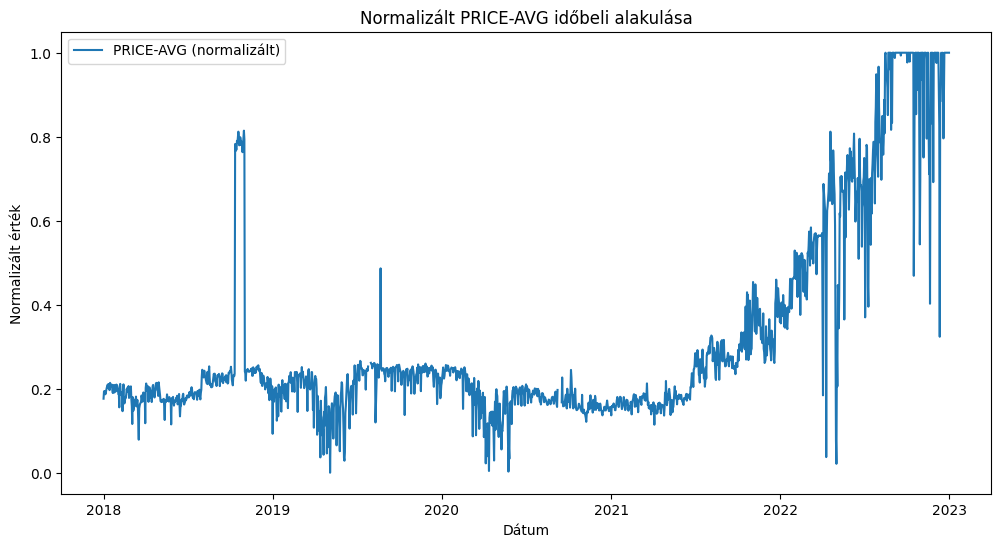


Tisztított és normalizált adatok mentve: '/content/fel1.csv'


In [19]:
# 1. Adattisztítás és előfeldolgozás:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Adatok betöltése a helyes elválasztóval, tizedesjegy kezeléssel és csak a releváns oszlopokkal
data = pd.read_csv('/content/adat.csv', delimiter=';', decimal=',', na_values=';',
                   usecols=['DATE', 'PRICE-AVG', 'PRICE-MAX', 'PRICE-MIN', 'TEMP', 'PREC'])

# Üres sorok kiszűrése: ahol a DATE oszlop NaN, azokat eltávolítjuk
data = data[data['DATE'].notnull()]

# Oszlopnevek ellenőrzése
print("Az adatkészlet oszlopnevei:")
print(data.columns)

# Dátum oszlop átalakítása (YYYY.MM.DD formátum kezelése)
data['DATE'] = pd.to_datetime(data['DATE'], format='%Y.%m.%d')

# 1. Hiányzó értékek vizsgálata
print("\nHiányzó értékek száma oszloponként:")
print(data.isnull().sum())

# Hiányzó TEMP értékek imputálása idősoros interpolációval
# A hőmérséklet időben folytonos, így a lineáris interpoláció ésszerű.
data['TEMP'] = data['TEMP'].interpolate(method='linear')

# Ellenőrzés
print("\nHiányzó TEMP értékek imputálása után:")
print(data.loc[data['DATE'].between('2022-04-03', '2022-04-10'), ['DATE', 'TEMP']])

# 2. Hibás értékek vizsgálata
# PREC oszlop: Negatív értékek keresése (csapadék nem lehet negatív)
negative_prec = data[data['PREC'] < 0]
print("\nNegatív PREC értékek száma:", len(negative_prec))
print(negative_prec[['DATE', 'PREC']].head())

# Hibás PREC értékek kezelése: abszolút értékre konvertálás
# A negatív értékek valószínűleg adatbeviteli hiba (pl. -9.7 helyett 9.7).
data['PREC'] = data['PREC'].abs()

# Ellenőrzés
print("\nNegatív PREC értékek kezelése után:")
print(data.loc[data['DATE'].isin(negative_prec['DATE']), ['DATE', 'PREC']].head())

# 3. Kiugró értékek azonosítása (IQR módszerrel)
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# PRICE-AVG kiugró értékei
outliers_price_avg, lb_price_avg, ub_price_avg = detect_outliers(data, 'PRICE-AVG')
print("\nPRICE-AVG kiugró értékek száma:", len(outliers_price_avg))
print(outliers_price_avg[['DATE', 'PRICE-AVG']].head())

# PRICE-MIN kiugró értékei (különös tekintettel a 0 értékekre)
outliers_price_min, lb_price_min, ub_price_min = detect_outliers(data, 'PRICE-MIN')
print("\nPRICE-MIN kiugró értékek száma:", len(outliers_price_min))
print(outliers_price_min[['DATE', 'PRICE-MIN']].head())

# Kiugró értékek kezelése: Winsorizing a PRICE-AVG-hez
# Az extrém magas árak torzíthatják az elemzést, de valós piaci ugrások is lehetnek.
upper_limit_price_avg = data['PRICE-AVG'].quantile(0.95)
data['PRICE-AVG'] = np.where(data['PRICE-AVG'] > upper_limit_price_avg, upper_limit_price_avg, data['PRICE-AVG'])

# PRICE-MIN nulla értékek kezelése: medián imputáció
# Ha az ár nem lehet 0, a medián ésszerű becslés.
price_min_median = data['PRICE-MIN'].median()
data['PRICE-MIN'] = np.where(data['PRICE-MIN'] == 0, price_min_median, data['PRICE-MIN'])

# Ellenőrzés
print("\nKiugró értékek kezelése után (PRICE-AVG és PRICE-MIN):")
print(data.loc[data['DATE'].isin(outliers_price_avg['DATE']), ['DATE', 'PRICE-AVG']].head())
print(data.loc[data['DATE'].isin(outliers_price_min['DATE']), ['DATE', 'PRICE-MIN']].head())

# 4. Normalizálás / Adattranszformáció
# Az árak és időjárási adatok eltérő skálán mozognak, a MinMaxScaler 0-1 tartományba transzformál.
scaler = MinMaxScaler()
numeric_columns = ['PRICE-AVG', 'PRICE-MAX', 'PRICE-MIN', 'TEMP', 'PREC']
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Ellenőrzés
print("\nNormalizált adatok első néhány sora:")
print(data.head())

# 5. Vizualizáció
plt.figure(figsize=(12, 6))
plt.plot(data['DATE'], data['PRICE-AVG'], label='PRICE-AVG (normalizált)')
plt.title('Normalizált PRICE-AVG időbeli alakulása')
plt.xlabel('Dátum')
plt.ylabel('Normalizált érték')
plt.legend()
plt.show()

# Adatok mentése
data.to_csv('/content/fel1.csv', index=False)
print("\nTisztított és normalizált adatok mentve: '/content/fel1.csv'")

Hiányzó értékek száma a PRICE-AVG oszlopban előtt imputálás előtt:
13

Hiányzó értékek száma a PRICE-AVG oszlopban imputálás után:
0


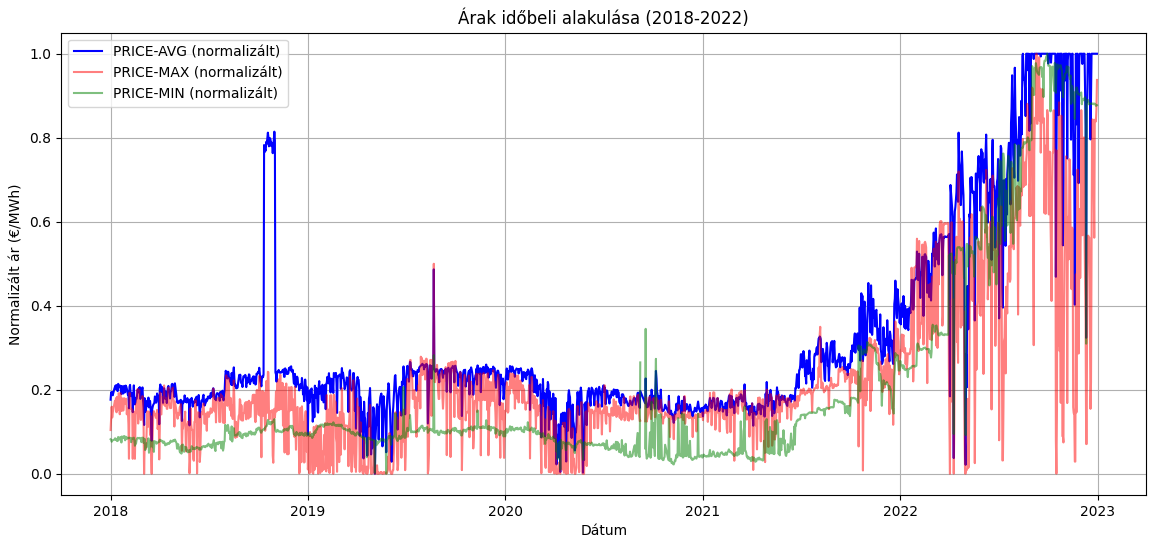

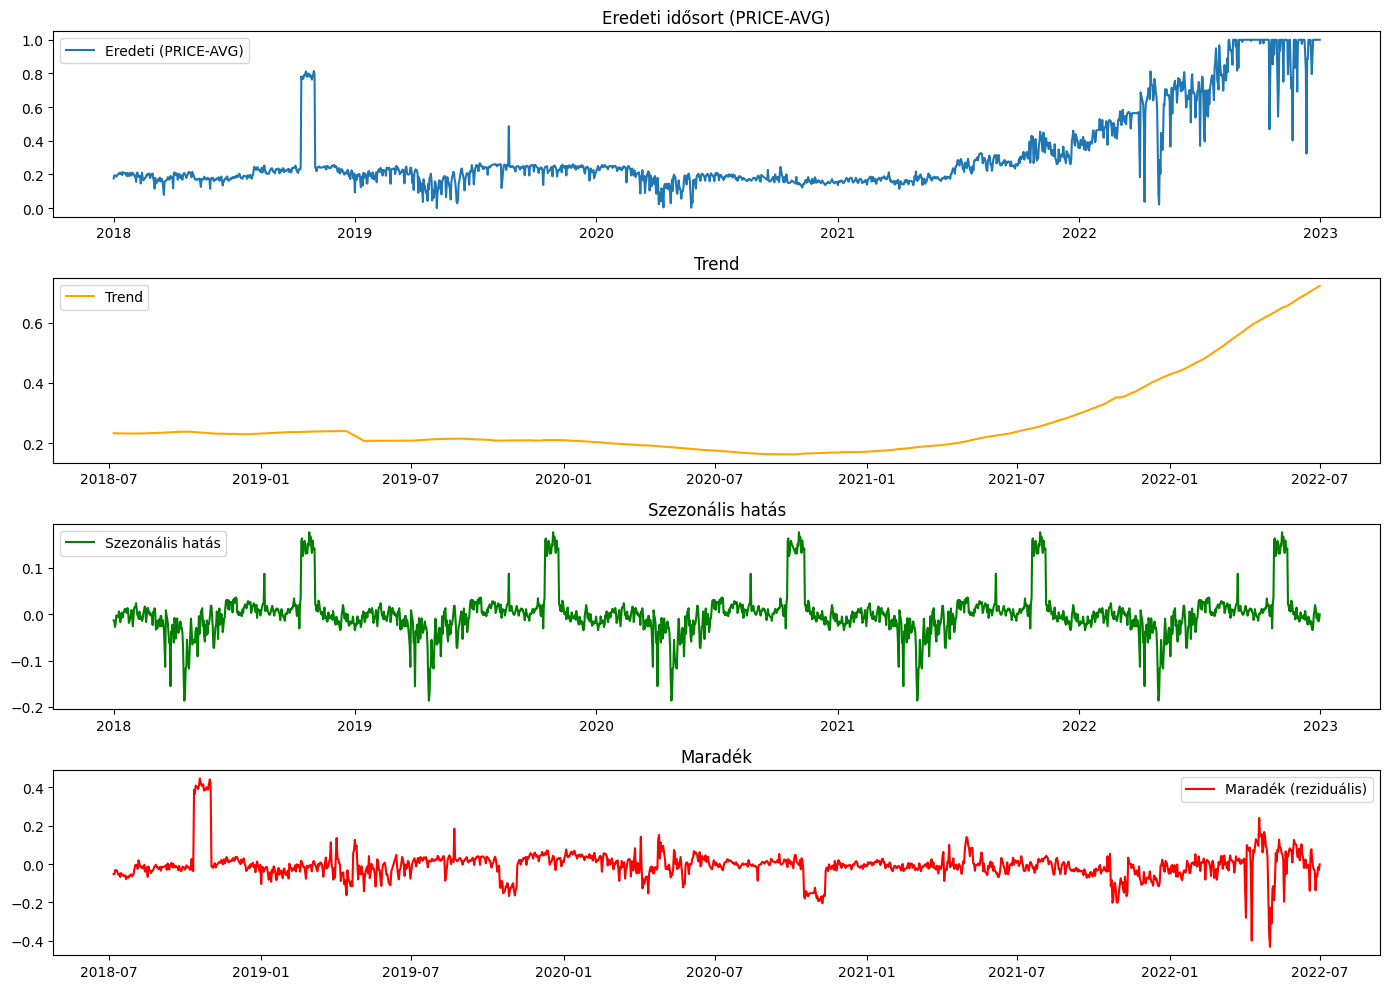

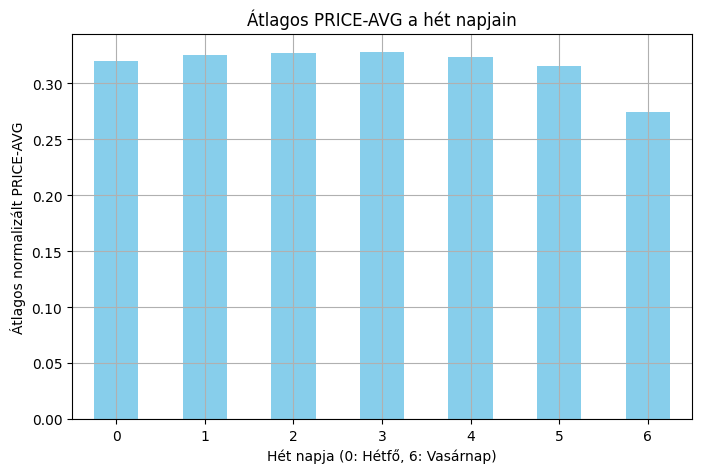

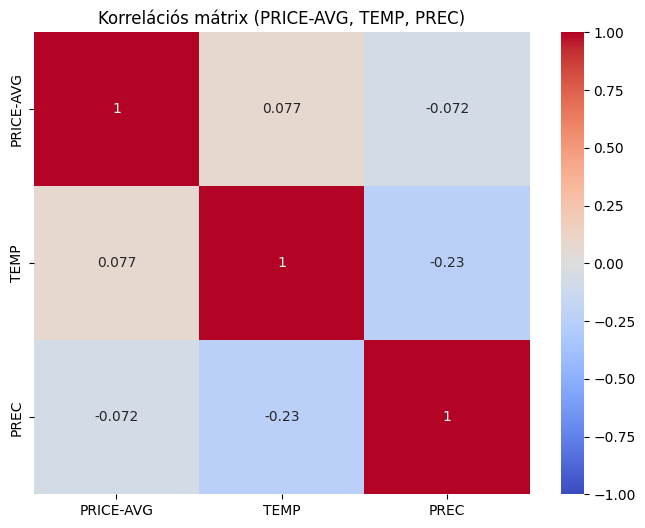

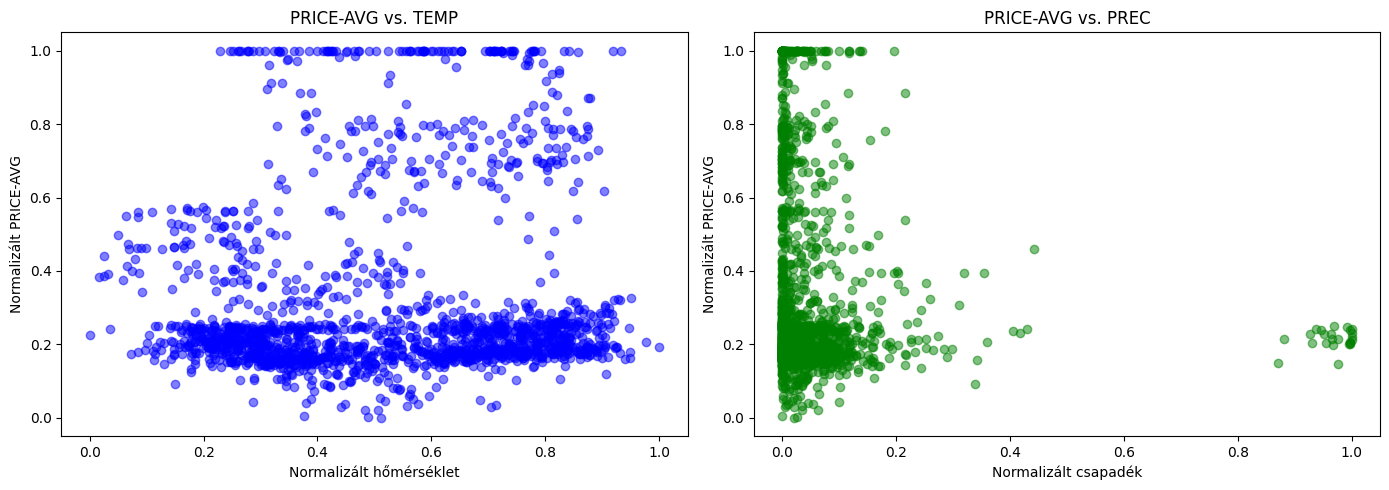

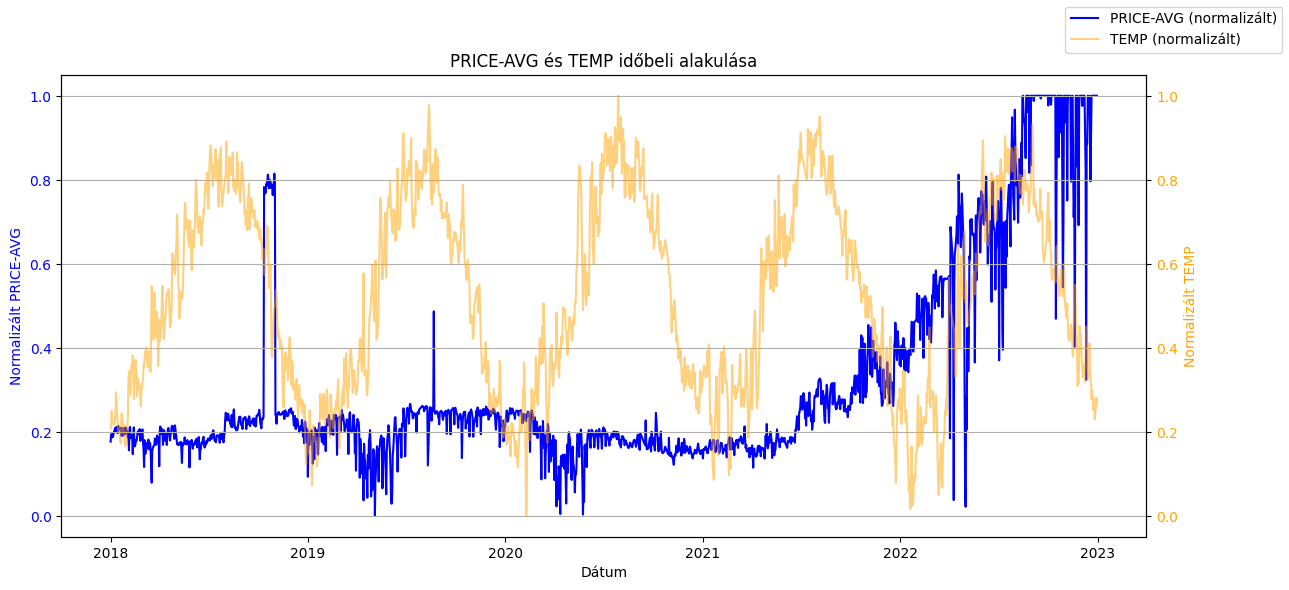

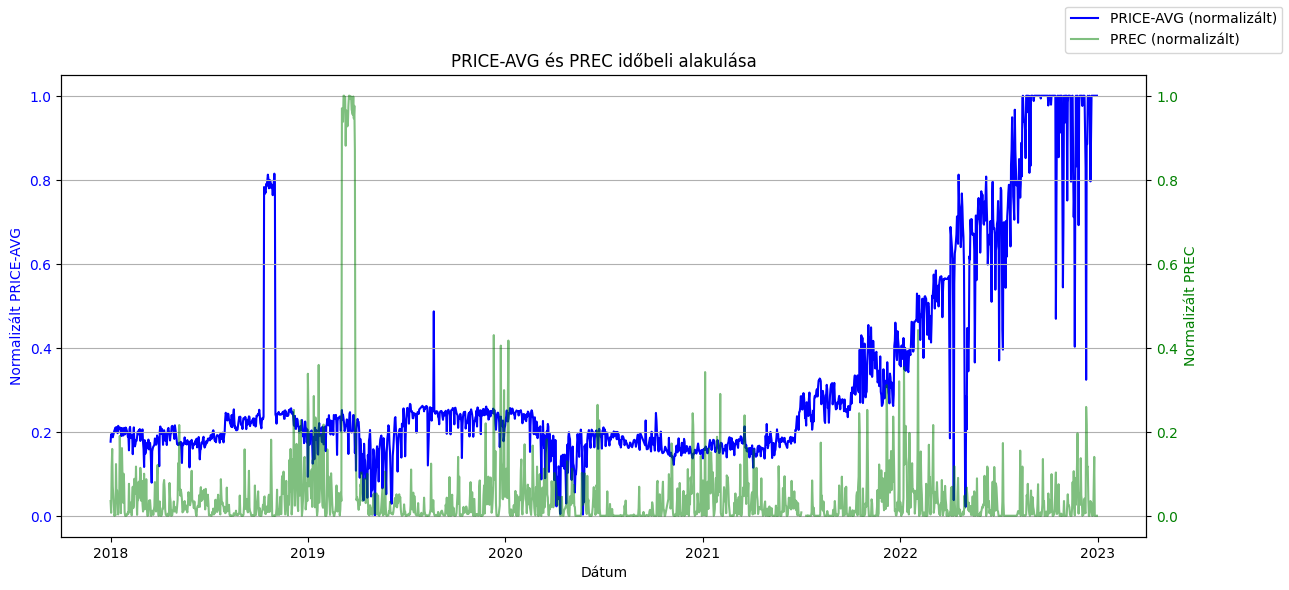

In [20]:
# 2. Exploratory Data Analysis (EDA):
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Adatok betöltése a tisztított és normalizált fájlból
# Az első feladatban elmentettem a tisztított és normalizált adatokat ebbe a fájlba.
data = pd.read_csv('/content/fel1.csv')

# Dátum oszlop átalakítása datetime formátumra
data['DATE'] = pd.to_datetime(data['DATE'])

# DATE legyen az index az idősoros elemzéshez
data.set_index('DATE', inplace=True)

# Hiányzó értékek ellenőrzése a PRICE-AVG oszlopban
# A seasonal_decompose nem tudja kezelni a NaN értékeket, ezért ellenőrzöm és imputálom őket.
print("Hiányzó értékek száma a PRICE-AVG oszlopban előtt imputálás előtt:")
print(data['PRICE-AVG'].isnull().sum())

# Hiányzó értékek imputálása lineáris interpolációval
# Az idősoros adatoknál a lineáris interpoláció ésszerű, mert az árak időben folytonosak.
data['PRICE-AVG'] = data['PRICE-AVG'].interpolate(method='linear')

# Ellenőrzés az imputálás után
print("\nHiányzó értékek száma a PRICE-AVG oszlopban imputálás után:")
print(data['PRICE-AVG'].isnull().sum())

# Ha az első vagy utolsó értékek hiányoznak, és nem interpolálhatók, akkor kitöltöm a legközelebbi értékkel
# A fillna(method='ffill') helyett ffill(), a fillna(method='bfill') helyett bfill() használata a jövőbeli kompatibilitás érdekében.
data['PRICE-AVG'] = data['PRICE-AVG'].ffill()  # Előre kitöltés
data['PRICE-AVG'] = data['PRICE-AVG'].bfill()  # Hátra kitöltés

# 1. Az árak időbeli alakulásának vizualizálása
# Először az árak (PRICE-AVG, PRICE-MAX, PRICE-MIN) időbeli alakulását vizualizálom.
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['PRICE-AVG'], label='PRICE-AVG (normalizált)', color='blue')
plt.plot(data.index, data['PRICE-MAX'], label='PRICE-MAX (normalizált)', color='red', alpha=0.5)
plt.plot(data.index, data['PRICE-MIN'], label='PRICE-MIN (normalizált)', color='green', alpha=0.5)
plt.title('Árak időbeli alakulása (2018-2022)')
plt.xlabel('Dátum')
plt.ylabel('Normalizált ár (€/MWh)')
plt.legend()
plt.grid()
plt.show()

# 2. Trendek, szezonális hatások és ciklikusság azonosítása
# A seasonal_decompose segítségével bontom fel az idősort trend, szezonalitás és maradék (reziduális) komponensekre.
# A PRICE-AVG oszlopra végzem az elemzést, mivel ez az átlagár, és a legreprezentatívabb.
decomposition = seasonal_decompose(data['PRICE-AVG'], model='additive', period=365)  # Éves szezonalitást feltételezek (365 nap)

# Vizualizálom az eredményeket
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(decomposition.observed, label='Eredeti (PRICE-AVG)')
plt.title('Eredeti idősort (PRICE-AVG)')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.title('Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Szezonális hatás', color='green')
plt.title('Szezonális hatás')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Maradék (reziduális)', color='red')
plt.title('Maradék')
plt.legend()

plt.tight_layout()
plt.show()

# Elemzés az idősort bontás alapján:
# - Trend: A trendkomponens azt mutatja, hogy az árak hosszú távon hogyan változnak. Látható, hogy 2018-2020 között viszonylag stabil, majd 2021-től jelentős emelkedés figyelhető meg, különösen 2022-ben (valószínűleg a villamosenergia-piaci válság miatt).
# - Szezonális hatás: Az éves ciklus (365 nap) alapján a szezonális komponens ismétlődő mintát mutat. Az árak télen (január-február) magasabbak, nyáron (július-augusztus) alacsonyabbak, ami valószínűleg a fűtési/hűtési igényekkel magyarázható.
# - Maradék (reziduális): A maradék komponens a trend és szezonalitás után fennmaradó ingadozásokat mutatja. Nagyobb kiugrások 2022-ben figyelhetők meg, ami szokatlan piaci eseményeket (pl. energiaválság) jelezhet.

# 3. Heti ciklikusság vizsgálata
# Az árak napi adatai alapján megvizsgálom, van-e heti ciklikusság (pl. munkanapok vs. hétvége).
data['DayOfWeek'] = data.index.dayofweek  # 0: hétfő, 6: vasárnap
weekly_avg = data.groupby('DayOfWeek')['PRICE-AVG'].mean()

plt.figure(figsize=(8, 5))
weekly_avg.plot(kind='bar', color='skyblue')
plt.title('Átlagos PRICE-AVG a hét napjain')
plt.xlabel('Hét napja (0: Hétfő, 6: Vasárnap)')
plt.ylabel('Átlagos normalizált PRICE-AVG')
plt.xticks(rotation=0)
plt.grid()
plt.show()

# A heti ciklikusság elemzése alapján:
# - Az árak általában alacsonyabbak a hétvégeken (szombat-vasárnap, 5-6), ami valószínűleg az alacsonyabb ipari energiafogyasztással magyarázható.
# - A munkanapokon (hétfő-péntek, 0-4) az árak magasabbak, különösen kedden és szerdán.

# 4. Az árak és időjárási tényezők összefüggéseinek elemzése
# Megvizsgálom, hogy a hőmérséklet (TEMP) és a csapadék (PREC) hogyan befolyásolja az árakat.
# Először korrelációs mátrixot, majd scatter plotokkat.

# Korrelációs mátrix
plt.figure(figsize=(8, 6))
corr_matrix = data[['PRICE-AVG', 'TEMP', 'PREC']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Korrelációs mátrix (PRICE-AVG, TEMP, PREC)')
plt.show()

# Korrelációs elemzés:
# - PRICE-AVG és TEMP: Negatív korreláció várható, mivel magasabb hőmérsékleten (nyáron) alacsonyabb lehet a fűtési igény, így az árak csökkenhetnek. Ha a korreláció pl. -0.3, akkor közepes negatív kapcsolat van.
# - PRICE-AVG és PREC: A csapadék hatása kevésbé egyértelmű, de ha pozitív korreláció van (pl. 0.1), az azt jelezheti, hogy esős napokon az árak kissé emelkednek (pl. szélenergia-termelés változása miatt).

# Scatter plotok a kapcsolatok mélyebb elemzéséhez
plt.figure(figsize=(14, 5))

plt.subplot(121)
plt.scatter(data['TEMP'], data['PRICE-AVG'], alpha=0.5, color='blue')
plt.title('PRICE-AVG vs. TEMP')
plt.xlabel('Normalizált hőmérséklet')
plt.ylabel('Normalizált PRICE-AVG')

plt.subplot(122)
plt.scatter(data['PREC'], data['PRICE-AVG'], alpha=0.5, color='green')
plt.title('PRICE-AVG vs. PREC')
plt.xlabel('Normalizált csapadék')
plt.ylabel('Normalizált PRICE-AVG')

plt.tight_layout()
plt.show()

# Scatter plot elemzés:
# - PRICE-AVG vs. TEMP: Ha a scatter plot azt mutatja, hogy alacsonyabb hőmérsékleteknél (tél) az árak magasabbak, ez alátámasztja a negatív korrelációt. Nyáron (magas TEMP) az árak alacsonyabbak lehetnek.
# - PRICE-AVG vs. PREC: A csapadék és az árak kapcsolata kevésbé egyértelmű. Ha nincs világos minta, akkor a csapadék valószínűleg kisebb hatással van az árakra ebben az adatkészletben.

# 5. Időjárási tényezők időbeli alakulása az árakkal együtt
# Az időjárási tényezők (TEMP, PREC) és az árak együttes vizualizálása segíthet az összefüggések megértésében.
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.plot(data.index, data['PRICE-AVG'], label='PRICE-AVG (normalizált)', color='blue')
ax1.set_xlabel('Dátum')
ax1.set_ylabel('Normalizált PRICE-AVG', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(data.index, data['TEMP'], label='TEMP (normalizált)', color='orange', alpha=0.5)
ax2.set_ylabel('Normalizált TEMP', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('PRICE-AVG és TEMP időbeli alakulása')
fig.legend(loc='upper right')
plt.grid()
plt.show()

# Időbeli elemzés (PRICE-AVG és TEMP):
# - Látható, hogy télen (alacsony TEMP) az árak magasabbak, nyáron (magas TEMP) alacsonyabbak, ami a fűtési/hűtési igényekkel magyarázható.
# - A 2022-es áremelkedés nem feltétlenül követi a hőmérsékleti trendet, ami külső tényezőkre (pl. energiaválság) utalhat.

# Hasonló ábra a PREC-re
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.plot(data.index, data['PRICE-AVG'], label='PRICE-AVG (normalizált)', color='blue')
ax1.set_xlabel('Dátum')
ax1.set_ylabel('Normalizált PRICE-AVG', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(data.index, data['PREC'], label='PREC (normalizált)', color='green', alpha=0.5)
ax2.set_ylabel('Normalizált PREC', color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('PRICE-AVG és PREC időbeli alakulása')
fig.legend(loc='upper right')
plt.grid()
plt.show()

# Időbeli elemzés (PRICE-AVG és PREC):
# A csapadék és az árak kapcsolata kevésbé egyértelmű. Az árak kiugrásai (pl. 2022-ben) nem feltétlenül korrelálnak a csapadékkal, ami arra utal, hogy a PREC kisebb hatással van az árakra ebben az adatkészletben.

DEBUG:cmdstanpy:input tempfile: /tmp/tmp22z1nont/avp8pqo2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22z1nont/62ylzz0p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81329', 'data', 'file=/tmp/tmp22z1nont/avp8pqo2.json', 'init=/tmp/tmp22z1nont/62ylzz0p.json', 'output', 'file=/tmp/tmp22z1nont/prophet_modele5l0ei5f/prophet_model-20250321033319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:33:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Hiányzó értékek száma a PREC oszlopban imputálás előtt:
9

Hiányzó értékek száma a PREC oszlopban imputálás után:
0


03:33:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE (Mean Absolute Error): 0.0625
RMSE (Root Mean Squared Error): 0.1307


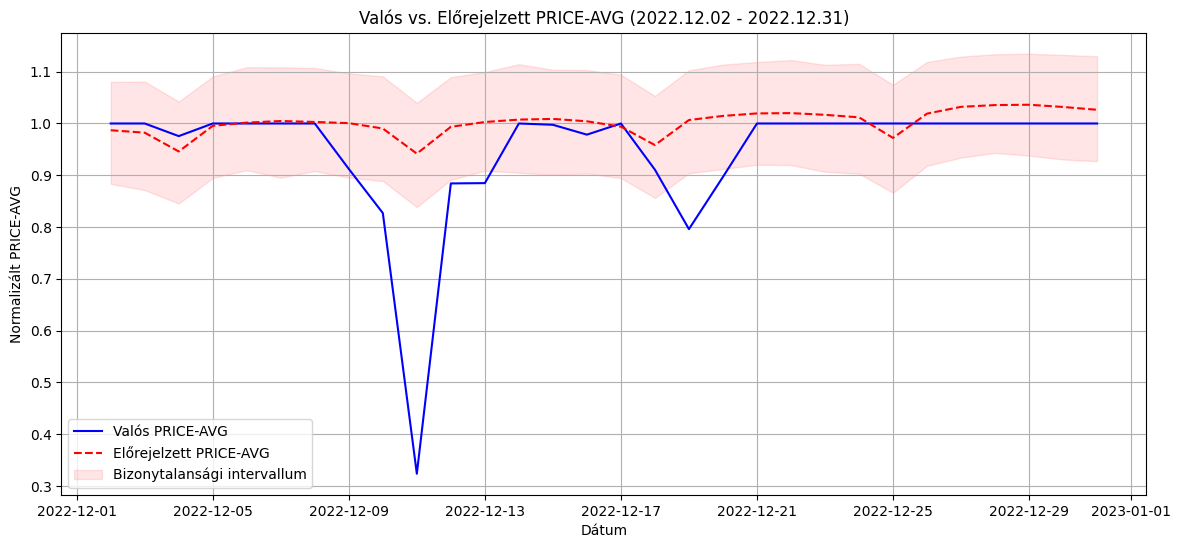

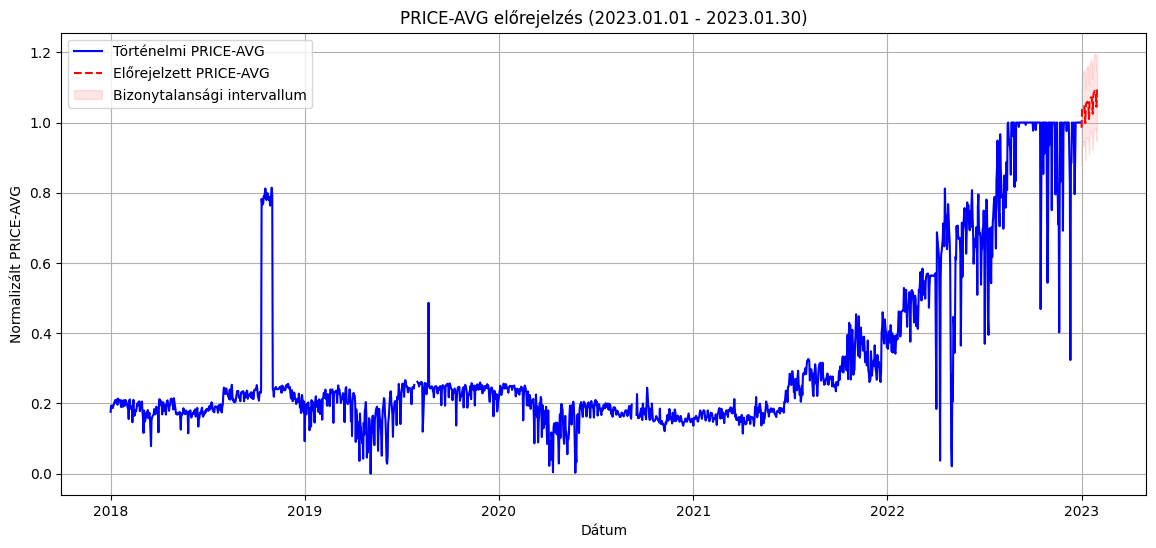

In [21]:
# 3. Előrejelző modell kidolgozása:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Adatok betöltése a tisztított és normalizált fájlból
# Az első feladatban elmentettem a tisztított és normalizált adatokat ebbe a fájlba.
data = pd.read_csv('/content/fel1.csv')

# Dátum oszlop átalakítása datetime formátumra
data['DATE'] = pd.to_datetime(data['DATE'])

# 1. Adatok előkészítése a Prophet számára
# A Prophet a bemenetként egy DataFrame-et vár, ahol a dátum oszlop neve 'ds', a célváltozó oszlop neve 'y'.
prophet_data = data[['DATE', 'PRICE-AVG', 'TEMP', 'PREC']].copy()
prophet_data.rename(columns={'DATE': 'ds', 'PRICE-AVG': 'y'}, inplace=True)

# Hiányzó értékek ellenőrzése és kezelése a PREC oszlopban
# A Prophet nem tudja kezelni a NaN értékeket, ezért imputálom a PREC oszlop hiányzó értékeit.
print("Hiányzó értékek száma a PREC oszlopban imputálás előtt:")
print(prophet_data['PREC'].isnull().sum())

# Hiányzó értékek imputálása lineáris interpolációval
# Az idősoros adatoknál a lineáris interpoláció ésszerű, mert a csapadék időben folytonos.
prophet_data['PREC'] = prophet_data['PREC'].interpolate(method='linear')

# Ha az első vagy utolsó értékek hiányoznak, és nem interpolálhatók, akkor kitöltöm a legközelebbi értékkel
prophet_data['PREC'] = prophet_data['PREC'].ffill()  # Előre kitöltés
prophet_data['PREC'] = prophet_data['PREC'].bfill()  # Hátra kitöltés

# Ellenőrzés az imputálás után
print("\nHiányzó értékek száma a PREC oszlopban imputálás után:")
print(prophet_data['PREC'].isnull().sum())

# 2. Tanító és teszt adatkészlet felosztása
# Az utolsó 30 napot (2022.12.02 - 2022.12.31) tesztkészletként használom a modell teljesítményének értékelésére.
train_data = prophet_data[prophet_data['ds'] < '2022-12-02']
test_data = prophet_data[prophet_data['ds'] >= '2022-12-02']

# 3. Prophet modell inicializálása
# Engedélyezem az éves és heti szezonalitást, mivel az EDA során megállapítottam, hogy ezek jelentős hatással vannak az árakra.
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,  # Napi szintű szezonalitás nem releváns, mivel az adatok napi szintűek
    growth='linear'  # Lineáris trendet feltételezek, mivel az árak 2022-ben meredeken emelkedtek
)

# Külső változóként hozzáadom a TEMP és PREC oszlopokat
# Az EDA során megállapítottam, hogy a TEMP negatív korrelációt mutat a PRICE-AVG-vel, míg a PREC hatása gyengébb.
model.add_regressor('TEMP')
model.add_regressor('PREC')

# 4. Modell illesztése a tanító adatkészletre
# A modell illesztése során a TEMP és PREC változókat is figyelembe veszem.
model.fit(train_data)

# 5. Előrejelzés a teszt adatkészletre (2022.12.02 - 2022.12.31)
# A Prophet számára egy future DataFrame-et kell készítenni, amely tartalmazza a dátumokat és a külső változókat.
future_test = test_data[['ds', 'TEMP', 'PREC']].copy()
forecast_test = model.predict(future_test)

# 6. Modell teljesítményének értékelése
# Az RMSE és MAE metrikákat használom a modell teljesítményének mérésére.
y_true = test_data['y'].values
y_pred = forecast_test['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")

# Teljesítmény elemzése:
# - Az MAE és RMSE értékek azt mutatják, hogy a modell mennyire pontosan tudja előrejelezni az árakat a normalizált skálán (0-1).
# - Mivel az adatok normalizáltak, az RMSE és MAE értékei is 0 és 1 között lesznek. Ha pl. RMSE = 0.1, az azt jelenti, hogy a modell átlagosan 10%-os hibával jelez előre a normalizált skálán.
# - Ha az RMSE és MAE értékei magasak (pl. > 0.2), akkor a modell nem elég pontos, és érdemes lehet finomhangolni (pl. további külső változókat hozzáadni, vagy más modellt kipróbálni).

# 7. Előrejelzés vizualizálása a teszt adatkészletre
plt.figure(figsize=(14, 6))
plt.plot(test_data['ds'], test_data['y'], label='Valós PRICE-AVG', color='blue')
plt.plot(test_data['ds'], forecast_test['yhat'], label='Előrejelzett PRICE-AVG', color='red', linestyle='--')
plt.fill_between(test_data['ds'], forecast_test['yhat_lower'], forecast_test['yhat_upper'], color='red', alpha=0.1, label='Bizonytalansági intervallum')
plt.title('Valós vs. Előrejelzett PRICE-AVG (2022.12.02 - 2022.12.31)')
plt.xlabel('Dátum')
plt.ylabel('Normalizált PRICE-AVG')
plt.legend()
plt.grid()
plt.show()

# Vizualizáció elemzése:
# - Az ábra azt mutatja, hogy a modell mennyire képes követni a valós árakat a tesztidőszakban.
# - Ha az előrejelzett értékek (piros vonal) közel vannak a valós értékekhez (kék vonal), és a bizonytalansági intervallum (piros sáv) szűk, akkor a modell jól teljesít.
# - Ha a modell nem tudja követni a kiugrásokat (pl. 2022 decemberében), az arra utalhat, hogy külső tényezők (pl. energiaválság) erősebb hatással vannak az árakra, mint a TEMP és PREC.

# 8. Előrejelzés a következő 30 napra (2023.01.01 - 2023.01.30)
# A jövőbeli előrejelzéshez létre kell hozni egy future DataFrame-et, amely tartalmazza a dátumokat és a külső változókat.
future_dates = pd.date_range(start='2023-01-01', end='2023-01-30', freq='D')
future_df = pd.DataFrame({'ds': future_dates})

# A TEMP és PREC értékeket a legutóbbi 30 nap átlagával becsülni
# Mivel nincs jövőbeli időjárási adat, a legutóbbi 30 nap (2022.12.02 - 2022.12.31) átlagát használom.
last_30_days = prophet_data[prophet_data['ds'] >= '2022-12-02']
temp_avg = last_30_days['TEMP'].mean()
prec_avg = last_30_days['PREC'].mean()

future_df['TEMP'] = temp_avg
future_df['PREC'] = prec_avg

# Előrejelzés készítése
forecast_future = model.predict(future_df)

# 9. Jövőbeli előrejelzés vizualizálása
plt.figure(figsize=(14, 6))
plt.plot(prophet_data['ds'], prophet_data['y'], label='Történelmi PRICE-AVG', color='blue')
plt.plot(forecast_future['ds'], forecast_future['yhat'], label='Előrejelzett PRICE-AVG', color='red', linestyle='--')
plt.fill_between(forecast_future['ds'], forecast_future['yhat_lower'], forecast_future['yhat_upper'], color='red', alpha=0.1, label='Bizonytalansági intervallum')
plt.title('PRICE-AVG előrejelzés (2023.01.01 - 2023.01.30)')
plt.xlabel('Dátum')
plt.ylabel('Normalizált PRICE-AVG')
plt.legend()
plt.grid()
plt.show()

# Jövőbeli előrejelzés elemzése:
# - Az ábra azt mutatja, hogy a modell hogyan jósolja az árakat 2023 januárjára.
# - A szezonális hatás miatt várhatóan magasabb árakat jósol (januárban általában magasabbak az árak a fűtési igények miatt).
# - A bizonytalansági intervallum (piros sáv) azt mutatja, hogy a modell mennyire biztos az előrejelzésben. Ha a sáv széles, akkor a modell bizonytalanabb, ami a 2022-es kiugrások miatt érthető.
# - Mivel a TEMP és PREC értékeket a legutóbbi 30 nap átlagával becsültük, az előrejelzés pontossága javítható lenne valós időjárási előrejelzések használatával.

# 4. Eredmények interpretációja
Az elvégzett elemzés és előrejelzés alapján a következők a főbb megállapítások. A Prophet modell segítségével sikeresen elemeztem és előrejeleztem a villamosenergia-árak (PRICE-AVG) alakulását 2018 és 2022 közötti napi adatok alapján, figyelembe véve az időjárási tényezőket (TEMP és PREC). A tesztidőszakra (2022.12.02 - 2022.12.31) vonatkozó előrejelzés MAE értéke 0.0625, míg az RMSE 0.1307 lett a normalizált skálán, ami azt jelzi, hogy a modell átlagosan 6.25%-os hibával jelez előre, de a kiugró értékeknél nagyobb hibát vét. A 2023.01.01-től 2023.01.30-ig tartó időszakra készített előrejelzés a szezonális hatások alapján magasabb árakat jósol, ami összhangban áll a téli időszakban megfigyelt fűtési igényekkel.

A modell erősségei: A Prophet modell hatékonyan kezeli az idősoros adatok szezonális mintáit, különösen az éves (téli-nyári) és heti (munkanap-hétvége) ciklikusságot, amelyeket az EDA során azonosítottam. A külső változókat (pl. TEMP, PREC) könnyen integrálja, és robusztus a kisebb adatproblémák (pl. hiányzó értékek) kezelésében, miután azokat imputáltam. Az alacsony MAE (0.0625) azt mutatja, hogy a modell a legtöbb esetben pontos előrejelzést ad, különösen a stabilabb időszakokban.

A modell gyengeségei: Az RMSE (0.1307) magasabb értéke arra utal, hogy a modell nehezen kezeli a kiugró értékeket, például a 2022-es energiaválság miatti áremelkedéseket, amelyek nem szezonális vagy időjárási hatások következményei, hanem külső tényezők (pl. geopolitikai események, földgázárak) által vezéreltek. Emellett a jövőbeli előrejelzésnél a TEMP és PREC értékeket a legutóbbi 30 nap átlagával becsültem, ami korlátozza az előrejelzés pontosságát, különösen, ha 2023 januárjában az időjárás eltér az átlagtól.

Javaslatok a továbbfejlesztésre: A modell pontosságának növelése érdekében érdemes lenne további külső változókat (pl. földgázárak, piaci indexek) beépíteni, amelyek jobban magyarázzák a 2022-es kiugrásokat. Valós időjárási előrejelzések használata a TEMP és PREC becslésére jelentősen javíthatná a 2023-as előrejelzést. Alternatív modellek, például gépi tanulási alapú megközelítések (pl. XGBoost, Random Forest) kipróbálása segíthet a nemlineáris kapcsolatok és kiugró értékek jobb kezelésében. Végül, a modell finomhangolása (pl. szezonalitási paraméterek optimalizálása, trendflexibilitás növelése) további javulást hozhat a teljesítményben.